<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты" data-toc-modified-id="Импорты-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Константы" data-toc-modified-id="Константы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Константы</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Подключение-GPU" data-toc-modified-id="Подключение-GPU-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подключение GPU</a></span></li><li><span><a href="#Изучение-датасета" data-toc-modified-id="Изучение-датасета-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Изучение датасета</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Общий план по выполнению проекта**

1. Загрузим и подготовим данные.
2. Обучим модель. 
3. Сделаем выводы.

Для выполнения проекта будем применять предобученную модель *BERT* с сайта huggingface.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

##Содержание
[Подготовка](#Подготовка)  
  - [Импорты](#Импорты)  
  - [Константы](#Константы)  
  - [Функции](#Функции)  
  - [Подключение GPU](#Подключение GPU)  
  - [Изучение датасета](#Изучение датасета)  
  - [Подготовка данных](#Подготовка данных)  

[Обучение](#Обучение)  
  - [Подготовка](#Подготовка)  
  - [Обучение](#Обучение)  
  - [Результаты](#Результаты)  
  
[Выводы](#Выводы)  

[Чек-лист проверки](#Чек-лист проверки)  

## Подготовка

Привет Ревьюер! Я Константин (путают с Дарьей) Так как в курсе было недостаточно информации для выполнения проекта с нейросетью, мне пришлось делать находя материалы в интернете. Было очень много интересной информации, но несколько вещей оказались непонятны, я понял что они нужны, но не понял как они действуют, ниже я о них спрошу. А также буду рассказывать о чем узнал, надеюсь ты сможешь меня где-то поправить, а где то поделиться интересной информацией =)   
Хочу отметить что проект я начал делать в Юпитере анакондовском локально, потом перешел в Колаб, но постарался сделать что бы и в Юпитерхабе от яндекса работало. Поэтому некоторые элементы кода я закоментировал.

### Импорты

In [ ]:
#pip install torch

In [ ]:
#pip install transformers

In [ ]:
#pip install keras_preprocessing

In [ ]:
import torch
import transformers
import random
import time
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import notebook
from pymystem3 import Mystem
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          AdamW, BertConfig, get_linear_schedule_with_warmup)
from torch.utils.data import (TensorDataset, DataLoader, 
                              RandomSampler, SequentialSampler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Константы

In [ ]:
model_path = "JungleLee/bert-toxic-comment-classification" # имя модели
MAX_LEN = 128 # максимальная длина предложений
RANDOM_STATE = 42 # заметил в интернете что этим переменным часто дают 
RANDOM_SEED = 42  # значение 42, интересна история этого факта =)
TEST_SIZE_1 = 0.4
TEST_SIZE_2 = 0.5
BATCH_SIZE = 64 # заметил что популярны степени двойки для подобных переменных
LEARNING_RATE = 2e-5
EPSILON = 1e-8 # для предотвращения деления на ноль
EPOCHS = 4

### Функции

In [ ]:
def clear_text(text):   
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [ ]:
def balance_info(x):
    print('Баланс классов в целевом признаке')
    print('-'*33)
    print(x.value_counts(normalize=True))
    print('-'*33)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat)

### Подключение GPU

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Найден GPU: {}'.format(device_name))
else:
    raise SystemError('GPU не найден')

Найден GPU: /device:GPU:0


In [ ]:
if torch.cuda.is_available():           
    device = torch.device("cuda")
    print('Доступен %d GPU.' % torch.cuda.device_count())
    print('Будет использован:', torch.cuda.get_device_name(0))

else:
    print('Нет доступных GPU, используем CPU.')
    device = torch.device("cpu")

Доступен 1 GPU.
Будет использован: Tesla T4


С использованием GPU полный порядок

### Изучение датасета

In [ ]:
try:
    df = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv'
        )
except FileNotFoundError:
    df = pd.read_csv(
        r'C:\Users\keyten\Desktop\Info\Learning DS\projects\toxic_comments\toxic_comments.csv'
        )
except:    
    df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/toxic_comments.csv'
        )

In [ ]:
df.sample(10)

,Unnamed: 0,text,toxic
150373,150529,(OH NO HOW WILL LIFE GO ON???),0
134044,134182,Ultra-heavy deuterium is a solid with massive ...,0
68929,68997,Hey thanks for fixing up those typos! I'm not ...,0
64597,64664,You may comment on my TODO wish if you please....,0
47447,47502,"""\n\nImage source problem with Image:Homeimage...",0
18835,18854,| class= start| importance= low,0
2406,2406,"Also, I am going warthog hunting tomorrow, and...",0
64737,64804,If you are implying that I have have infringed...,0
28791,28828,REDIRECT Talk:Empress Elisabeth of Austria,0
137326,137464,"It's a few years too late, but, yes, it's the ...",0


In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [ ]:
df.shape

(159292, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
balance_info(df.toxic)

Баланс классов в целевом признаке
---------------------------------
0    0.898388
1    0.101612
Name: toxic, dtype: float64
---------------------------------


Сильный дисбаланс классов, в остальном данные в порядке, нужны только 2 ячейки text и toxic (возможно нужен апсемплинг)

### Подготовка данных

Очистим тексты от лишних символов

In [ ]:
df['clear_text'] = df['text'].apply(lambda x : clear_text(x))
df.sample(5)

,Unnamed: 0,text,toxic,clear_text
105833,105930,"""\nIs the word """"must"""" or """"should""""? I have ...",0,Is the word must or should I have no problem e...
151042,151198,Plagiarized from ... \n\nhttp://www.launceston...,0,Plagiarized from http www launcestoncataractgo...
46528,46583,"FYI, I thought he linked to Hulu which is a pa...",0,FYI I thought he linked to Hulu which is a par...
70694,70764,Japanese Scene \n\nThe largely neoclassical Ja...,0,Japanese Scene The largely neoclassical Japane...
80169,80245,Thanks for the explanation!,0,Thanks for the explanation


Разделим разметку и тексты

In [ ]:
sentences = df.clear_text.values
labels = df.toxic.values

Загрузим токенизатор

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=True)

In [ ]:
print('Оригинальный текст: ', sentences[0])
print('Длина оригинального текста: ', len(sentences[0].split()), 'слов')
print('Токены: ', tokenizer.tokenize(sentences[0]))
print('Длина списка токенов: ', len(tokenizer.tokenize(sentences[0])))
print('Id токенов: ', tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize(sentences[0])))
print('Длина списка id: ', len(tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize(sentences[0]))))

Оригинальный текст:  Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now
Длина оригинального текста:  46 слов
Токены:  ['explanation', 'why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'hardcore', 'metallic', '##a', 'fan', 'were', 'reverted', 'they', 'weren', 't', 'van', '##dal', '##isms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fa', '##c', 'and', 'please', 'don', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'm', 'retired', 'now']
Длина списка токенов:  52
Id токенов:  [7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 4694, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 227

Мы убедились что токенизатор работает, но хочу отметить что он далек от  совершенства на мой взгляд.  
  Примеры:   
  username - 'user' '##name'   
  Metallica - 'metallic', '##a'   
  vandalisms - 'van', '##dal', '##isms'  
  FAC - 'fa', '##c'

In [ ]:
print('Максимальная длина: ', max([len(sen) for sen in sentences]), 'символов')
print('Максимальная длина: ', max([len(sen.split()) for sen in sentences]), 'слов')

Максимальная длина:  5000 символов
Максимальная длина:  1403 слов


Тексты длиннющие, но мы их обрежем

Токенизируем тексты

In [ ]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True,
                        )
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 256). Running this sequence through the model will result in indexing errors


In [ ]:
print('Максимальная длина: ', max([len(sen) for sen in input_ids]))

Максимальная длина:  2502


После кодирования длина увеличилась потому что некоторые слова токенизатор разбивает на 2 и больше

Проведем паддинг

In [ ]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
print('Максимальная длина после паддинга: ', max(
    [len(sen) for sen in input_ids]))
print('Минимальная длина после паддинга: ', min(
    [len(sen) for sen in input_ids]))

Максимальная длина после паддинга:  128
Минимальная длина после паддинга:  128


Длина такая как и планировалось

Создадим маску

In [ ]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

Разделим данные на 3 выборки

In [ ]:
train_inputs, pack_inputs,\
train_labels, pack_labels = train_test_split(
    input_ids, labels,random_state=RANDOM_STATE, test_size=TEST_SIZE_1)
    
validation_inputs, test_inputs,\
validation_labels, test_labels = train_test_split(
    pack_inputs, pack_labels,random_state=RANDOM_STATE, test_size=TEST_SIZE_2)
    
train_masks, pack_masks,\
_, pack_labels = train_test_split(
     attention_masks, labels,random_state=RANDOM_STATE, test_size=TEST_SIZE_1)
     
validation_masks, test_masks,\
_, _ = train_test_split(
     pack_masks, pack_labels,random_state=RANDOM_STATE, test_size=TEST_SIZE_2)

In [ ]:
print('Тренировочная выборка')
balance_info(pd.Series(train_labels))
print('Валидационная выборка')
balance_info(pd.Series(validation_labels))
print('Тестовая выборка')
balance_info(pd.Series(test_labels))

Тренировочная выборка
Баланс классов в целевом признаке
---------------------------------
0    0.897609
1    0.102391
dtype: float64
---------------------------------
Валидационная выборка
Баланс классов в целевом признаке
---------------------------------
0    0.898895
1    0.101105
dtype: float64
---------------------------------
Тестовая выборка
Баланс классов в целевом признаке
---------------------------------
0    0.900217
1    0.099783
dtype: float64
---------------------------------


Применение стратификации приводило к ошибке в обучении, оставим разделение на выборки без стратификации

Переведем выборки в подходящий для модели формат

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

Создадим итератор для ускорения работы модели


In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=BATCH_SIZE
    )

validation_data = TensorDataset(
    validation_inputs, validation_masks, validation_labels
    )
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE
    )

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(
    test_data, sampler=test_sampler, batch_size=BATCH_SIZE
    )

Данные готовы к обучению, осталось подготовить модель

## Обучение

### Подготовка

Загрузим модель

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_path, num_labels=2, 
    output_attentions = False, 
    output_hidden_states = False
    )
model.cuda()

Загрузим алгоритм оптимизации

In [ ]:
optimizer = AdamW(model.parameters(),lr = LEARNING_RATE,eps = EPSILON)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Загрузим планировщик скорости обучения

In [ ]:
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Установим seed'ы для воспроизводимости

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

Объявим список для сбора потерь

In [ ]:
loss_values = []

### Обучение

Приступаем к тренировке модели

In [ ]:
# Обучение
for epoch_i in range(0, EPOCHS):
    print("")
    print('======== Эпоха {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Обучение...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        
        if step % 200 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Батч {:>5,}  из  {:>5,}.    Прошедшее время: {:}.'.format(
                step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("")
    print("  Средняя потеря при обучении: {0:.2f}".format(avg_train_loss))
    print("  Эпоха обучения заняла: {:}".format(format_time(time.time() - t0)))

# Валидация

    print("")
    print("Запуск Валидации...")

    t0 = time.time()
    model.eval()
    eval_loss, eval_f1 = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_f1 = flat_f1(logits, label_ids)
        eval_f1 += tmp_eval_f1
        nb_eval_steps += 1

    print("  F1: {0:.2f}".format(eval_f1/nb_eval_steps))
    print("  Валидация заняла: {:}".format(format_time(time.time() - t0)))

print("")
print("Обучение закончено!")


======== Эпоха 1 / 4 ========
Обучение...
  Батч   200  из  1,494.    Прошедшее время: 0:04:05.
  Батч   400  из  1,494.    Прошедшее время: 0:08:15.
  Батч   600  из  1,494.    Прошедшее время: 0:12:26.
  Батч   800  из  1,494.    Прошедшее время: 0:16:38.
  Батч 1,000  из  1,494.    Прошедшее время: 0:20:49.
  Батч 1,200  из  1,494.    Прошедшее время: 0:25:01.
  Батч 1,400  из  1,494.    Прошедшее время: 0:29:12.

  Средняя потеря при обучении: 0.08
  Эпоха обучения заняла: 0:31:09

Запуск Валидации...
  F1: 0.85
  Валидация заняла: 0:03:48

======== Эпоха 2 / 4 ========
Обучение...
  Батч   200  из  1,494.    Прошедшее время: 0:04:11.
  Батч   400  из  1,494.    Прошедшее время: 0:08:22.
  Батч   600  из  1,494.    Прошедшее время: 0:12:33.
  Батч   800  из  1,494.    Прошедшее время: 0:16:44.
  Батч 1,000  из  1,494.    Прошедшее время: 0:20:54.
  Батч 1,200  из  1,494.    Прошедшее время: 0:25:05.
  Батч 1,400  из  1,494.    Прошедшее время: 0:29:17.

  Средняя потеря при обучен

Потери снижаются на каждой эпохе, F1 не снижается, значит переобучение отсутствует

### Результаты

Посмотрим график потерь

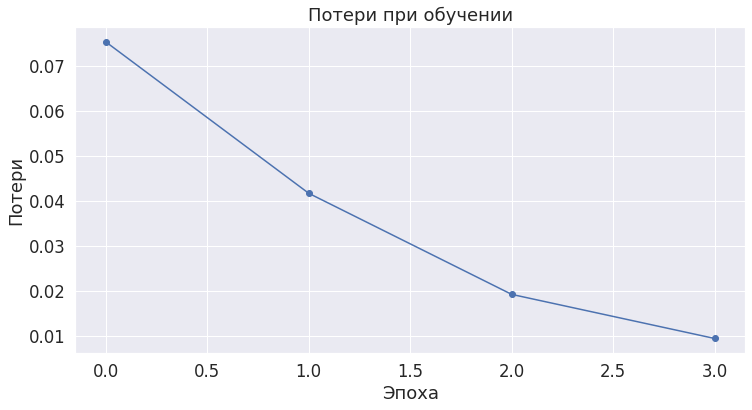

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Потери при обучении")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.show();

Потери очень низкие и с каждой эпохой они снижаются

Проверим модель на тестовой выборке

In [ ]:
model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
      
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
f1_set = []

for i in range(len(true_labels)):  
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()  
  f1 = f1_score(pred_labels_i, true_labels[i])                
  f1_set.append(f1)

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

f1 = f1_score(flat_true_labels, flat_predictions)

print('F1: %.3f' % f1)

F1: 0.860


Метрика показала удовлетворяющие условию задачи результаты.

## Выводы

Данные были получены в хорошем состоянии, но в них обнаружен сильный дисбаланс классов: 90% - 0, 10% - 1.

Из текстов были удалены лишние символы, тексты перекодированы, длинные обрезаны до размера 128 id, создана маска, данные разделены на 3 выборки с учетом сохранения соотношения классов, выборки переведены в формат тензоров.

Для ускорения работы модели выборки были помещены в итератор DataLoader и поделены на батчи размером 64, были инициированы оптимизатор AdamW, планировщик.

При обучении модели использовались GPU, forward propagation, backward propagation и сброс градиента. В результате модель показывала стабильное снижение показателя потерь и метрику F1 равную 85%

При проверке модели на тестовой выборке метрика F1 показала результат 86%.

Модель готова для поиска токсичных комментариев.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны